In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

In [4]:
data_path = Path("../data/processed/clean/clean_events.csv")
if not data_path.exists():
    raise FileNotFoundError(f"Data file not found at {data_path}")

df = pd.read_csv(data_path)
print(f"Data loaded with {df.shape[0]} rows and {df.shape[1]} columns.")


Data loaded with 490 rows and 9 columns.


In [5]:
# Basic Dataset Check -- Should be 0 all the way arounf

df.info()

#Column Information
print("\nColumn Information:")
for col in df.columns:
    non_null = df[col].notnull().sum()
    null_pct = df[col].isnull().mean() * 100

    print(f"{col:15} | Non-null: {non_null:>6} | Null %: {null_pct:>5.2f} | ")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   event          490 non-null    int64 
 1   meet           490 non-null    object
 2   stroke         490 non-null    object
 3   gender         490 non-null    object
 4   distance       490 non-null    int64 
 5   source_file    490 non-null    object
 6   meet_category  490 non-null    object
 7   records        490 non-null    object
 8   entries        490 non-null    object
dtypes: int64(2), object(7)
memory usage: 34.6+ KB

Column Information:
event           | Non-null:    490 | Null %:  0.00 | 
meet            | Non-null:    490 | Null %:  0.00 | 
stroke          | Non-null:    490 | Null %:  0.00 | 
gender          | Non-null:    490 | Null %:  0.00 | 
distance        | Non-null:    490 | Null %:  0.00 | 
source_file     | Non-null:    490 | Null %:  0.00 | 
meet_category   | Non-null:

In [6]:
# Sample Data

display(df.head())

sample_event = df.iloc[1]

records = ast.literal_eval(sample_event['records'])
entries = ast.literal_eval(sample_event['entries'])

print("Records:")
for record in records:
    print(f"  - {record}")

print("\nEntries:")
for entry in entries:
    print(f"  - {entry}")

,event,meet,stroke,gender,distance,source_file,meet_category,records,entries
0,1,2021 Speedo Summer Championships West Meet...,Butterfly,Women,200,2021-speedo-summer-championships---west---meet...,national-championships,"[['American', '2:04.14', '7/30/2009', 'Mary De...","[[1, 'Kozan, Justina', 17, 'Mission Viejo Nada..."
1,2,2021 Speedo Summer Championships West Meet...,Butterfly,Men,200,2021-speedo-summer-championships---west---meet...,national-championships,"[['World', '1:50.73', '7/24/2019', 'Kristof Mi...","[[1, 'Julian, Trenton', 22, 'Rose Bowl Aquatic..."
2,3,2021 Speedo Summer Championships West Meet...,Freestyle,Women,100,2021-speedo-summer-championships---west---meet...,national-championships,"[['World', '51.71', '7/23/2017', 'Sarah Sjostr...","[[1, ""O'Dell, Teagan"", 14, 'Irvine Novaquatics..."
3,4,2021 Speedo Summer Championships West Meet...,Freestyle,Men,100,2021-speedo-summer-championships---west---meet...,national-championships,"[['World', '46.91', '7/30/2009', 'Cesar Cielo'...","[[1, 'Novak, Jesse', 26, 'Irvine Novaquatics-C..."
4,8,2021 Speedo Summer Championships West Meet...,Freestyle,Women,200,2021-speedo-summer-championships---west---meet...,national-championships,"[['World', '1:52.98', '7/29/2009', 'Federica P...","[[1, 'Kozan, Justina', 17, 'Mission Viejo Nada..."


Records:
  - ['World', '1:50.73', '7/24/2019', 'Kristof Milak', 'HUN']
  - ['American', '1:51.51', '7/29/2009', 'Michael Phelps', 'USA']
  - ['U.S. Open', '1:52.20', '7/2/2008', 'Michael Phelps', 'Club Wolverine']

Entries:
  - [1, 'Julian, Trenton', 22, 'Rose Bowl Aquatics-CA', '1:57.35', '1:54.71']
  - [2, 'Homans, Harry', 21, 'Trojan Aquatics Swim Club-CA', '1:59.67', '1:59.32']
  - [3, 'Lustig, Jack', 18, 'Schroeder YMCA Swim Team-WI', '2:00.61', '2:00.22']
  - [4, 'Louser, Jason', 20, 'California Aquatics-PC', '2:01.04', '2:00.66']
  - [5, 'Reiter, Drew', 17, 'Greater Des Moines YMCA-IA', '2:03.61', '2:01.98']
  - [6, 'Keough, Patrick', 17, 'King Aquatic Club-PN', '2:03.69', '2:02.93']
  - [7, 'Hochwalt, Michael', 15, 'Spokane Waves Aquatic Team-IE', '2:02.27', '2:03.46']
  - [8, 'Boylan, David', 20, 'Craw(cid:976)ish Aquatics-LA', '2:02.81', '2:04.47']
  - [9, 'Naughton, Haakon', 17, 'Riptide-MN', '2:03.95', '2:02.29']
  - [10, 'Bonilla Flores, Roberto', 16, 'The Woodlands Swim T

In [7]:
# Helper functions for counting records and entries
def count_records(records_str):
    try:
        records = ast.literal_eval(records_str)
        return len(records)
    except (ValueError, SyntaxError):
        return 0

def count_entries(entries_str):
    try:
        entries = ast.literal_eval(entries_str)
        return len(entries)
    except (ValueError, SyntaxError):
        return 0
    
# Add columns for info
df['num_entries'] = df['entries'].apply(count_entries)
df['num_records'] = df['records'].apply(count_records)

print("Basic Stats:")
print(f"Total Events: {df.shape[0]}")
print(f"Total Records: {df['num_records'].sum()}")
print(f"Total Entries: {df['num_entries'].sum()}")
print(f"Unique Meets: {df['meet'].nunique():,}")
for meet in df['meet'].unique():
    print(f"  - {meet}: {df[df['meet'] == meet].shape[0]:,} events")
print(f"Meet Categories: {df['meet_category'].nunique():,}")
for meet in df['meet_category'].unique():
    print(f"  - {meet}: {df[df['meet_category'] == meet].shape[0]:,} events")


Basic Stats:
Total Events: 490
Total Records: 1376
Total Entries: 15215
Unique Meets: 16
  - 2021 Speedo Summer Championships   West   Meet Results: 24 events
  - Phillips 66 Intl Team Trials  : 34 events
  - 2021 Speedo Summer Championships East  : 25 events
  - 2023 Tyr Pro Championships Complete Meet Results: 28 events
  - Complete Meet Results 2023 Tyr Pro Swim Series Fort Lauderdale: 34 events
  - 2022 Tyr Pss Mv: 28 events
  - Knoxville: 28 events
  - 2023 Tyr Pro Swim Series Mission Viejo: 34 events
  - Santa Clara   Final Results: 42 events
  - Tyr Pss Richmond Full Meet Results: 27 events
  - 2023 Tyr Pro Swim Series Knoxville Meet Results: 34 events
  - 2025 Pss Westmont Complete Meet Results: 34 events
  - 2022 Tyr Pro Swim Series San Antonio   Complete Meet Results: 28 events
  - 2023 Tyr Pro Swim Series Westmont: 34 events
  - U S Olympic Team Trials   Wave Ii Complete Meet Results: 28 events
  - 2020 Us Olympic Team Trials   Complete Wave I Results: 28 events
Meet Categor

In [8]:
# Basic stats for columns
print("\nBasic Stats for Columns:")
print("num_entries:")
print(df["num_entries"].describe())
print("Distribution of events by type:")
print(df.groupby(['gender', 'distance', 'stroke']).size().sort_values(ascending=False))


Basic Stats for Columns:
num_entries:
count    490.000000
mean      31.051020
std       17.721299
min        2.000000
25%       19.000000
50%       28.000000
75%       40.000000
max      109.000000
Name: num_entries, dtype: float64
Distribution of events by type:
gender  distance  stroke      
Men     50        Freestyle       17
Women   50        Freestyle       17
Men     400       IM              16
Women   200       Freestyle       16
                  Breaststroke    16
                  Backstroke      16
        100       Freestyle       16
                  Butterfly       16
                  Breaststroke    16
                  Backstroke      16
        200       IM              16
        400       Freestyle       16
                  IM              16
        200       Butterfly       16
Men     400       Freestyle       16
        200       IM              16
                  Freestyle       16
                  Butterfly       16
                  Breaststroke    16
 

In [9]:
knockout_mask = df['stroke'].str.contains('knockout', case=False, na=False)
print("\nKnockout Events:")
print(f"Total Knockout Events: {knockout_mask.sum()}")
print(df[knockout_mask]['num_entries'])
print(df[knockout_mask]['meet'].value_counts())

#df['stroke'] = df['stroke'].astype(str).str.replace(' Knockout', '', regex=False)
#df['stroke'] = df['stroke'].astype(str).str.replace('(cid:976)', 'f', regex=False)

print(df.groupby(['gender', 'distance', 'stroke']).size().sort_values(ascending=False))






Knockout Events:
Total Knockout Events: 0
Series([], Name: num_entries, dtype: int64)
Series([], Name: count, dtype: int64)
gender  distance  stroke      
Men     50        Freestyle       17
Women   50        Freestyle       17
Men     400       IM              16
Women   200       Freestyle       16
                  Breaststroke    16
                  Backstroke      16
        100       Freestyle       16
                  Butterfly       16
                  Breaststroke    16
                  Backstroke      16
        200       IM              16
        400       Freestyle       16
                  IM              16
        200       Butterfly       16
Men     400       Freestyle       16
        200       IM              16
                  Freestyle       16
                  Butterfly       16
                  Breaststroke    16
                  Backstroke      16
        100       Freestyle       16
                  Butterfly       16
                  Breaststroke

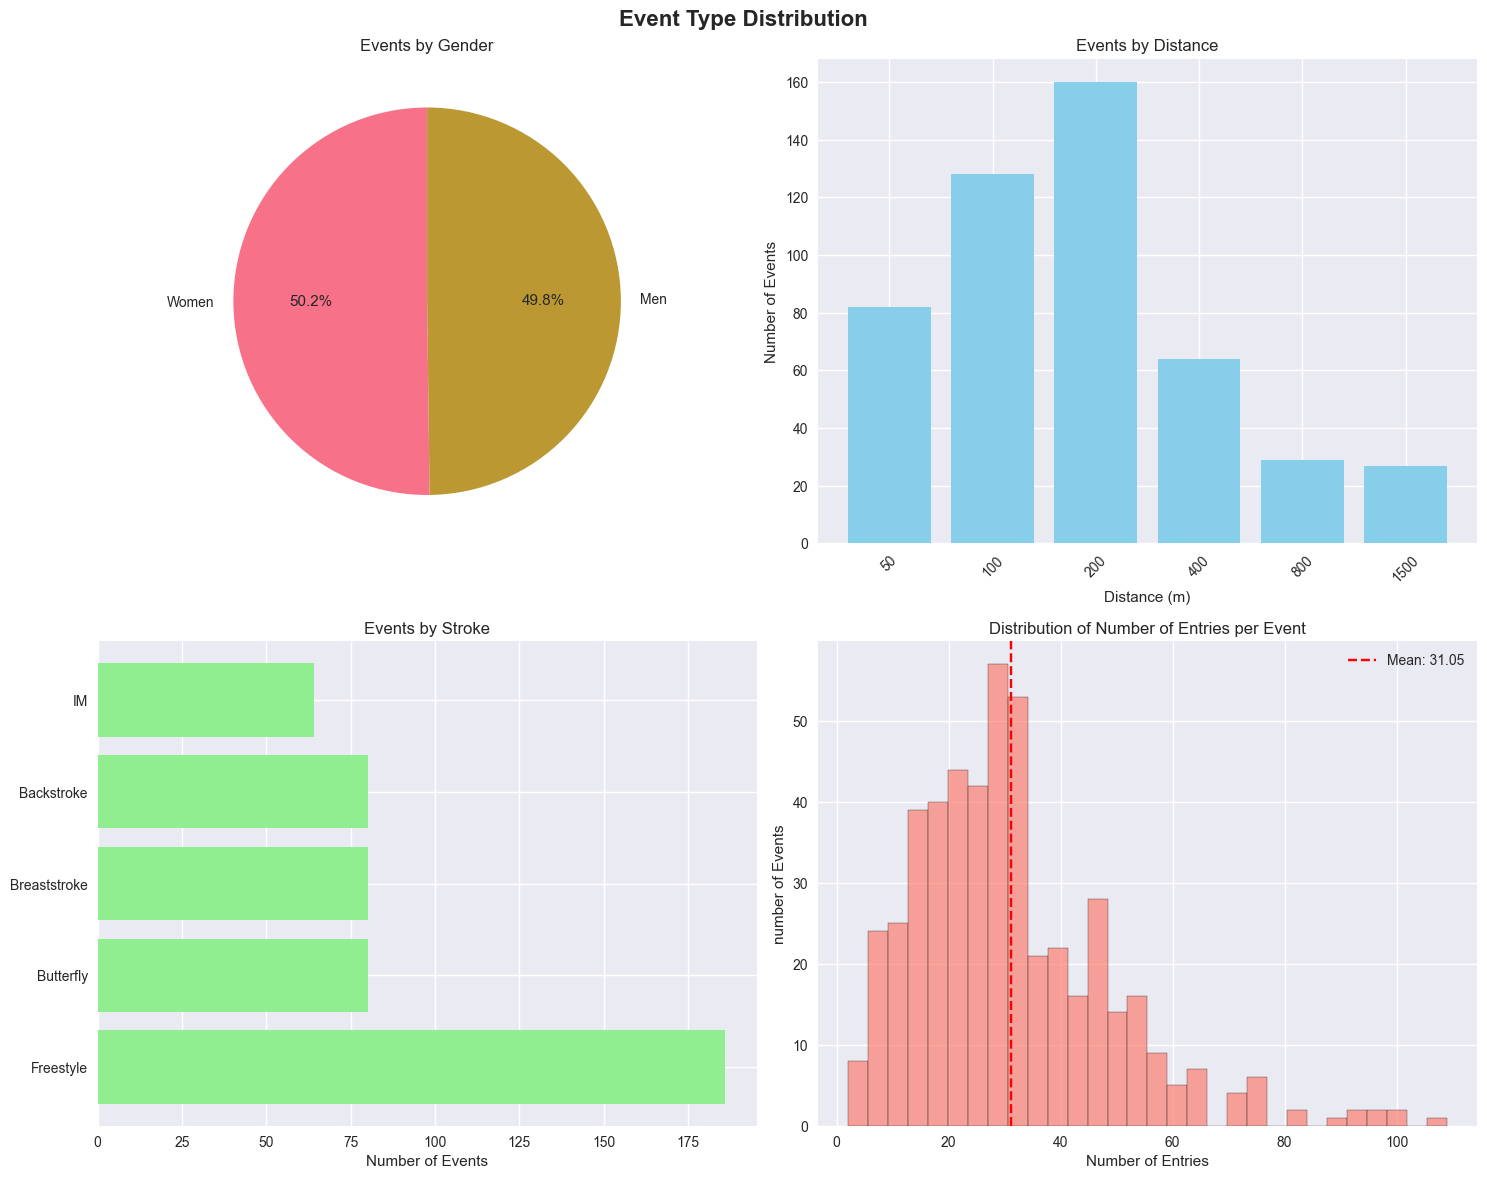

In [11]:
# Event Type Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Event Type Distribution', fontsize=16, fontweight='bold')

gender_counts = df['gender'].value_counts()
axes[0, 0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Events by Gender')

distance_counts = df['distance'].value_counts().sort_index()
axes[0, 1].bar(distance_counts.index.astype(str), distance_counts.values, color='skyblue')
axes[0, 1].set_title('Events by Distance')
axes[0, 1].set_xlabel('Distance (m)')
axes[0, 1].set_ylabel('Number of Events')
axes[0, 1].tick_params(axis='x', rotation=45)

stroke_counts = df['stroke'].value_counts()
axes[1, 0].barh(stroke_counts.index.astype(str), stroke_counts.values, color='lightgreen')
axes[1, 0].set_title('Events by Stroke')
axes[1, 0].set_xlabel('Number of Events')

axes[1, 1].hist(df['num_entries'], bins=30, alpha=0.7,color='salmon', edgecolor='black')
axes[1, 1].set_title('Distribution of Number of Entries per Event')
axes[1, 1].set_xlabel('Number of Entries')
axes[1, 1].set_ylabel('number of Events')
axes[1, 1].axvline(df['num_entries'].mean(), color='red', linestyle='--', label=f'Mean: {df["num_entries"].mean():.2f}')

axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../outputs/plots/event_type_distribution.png', dpi=300)
plt.show()

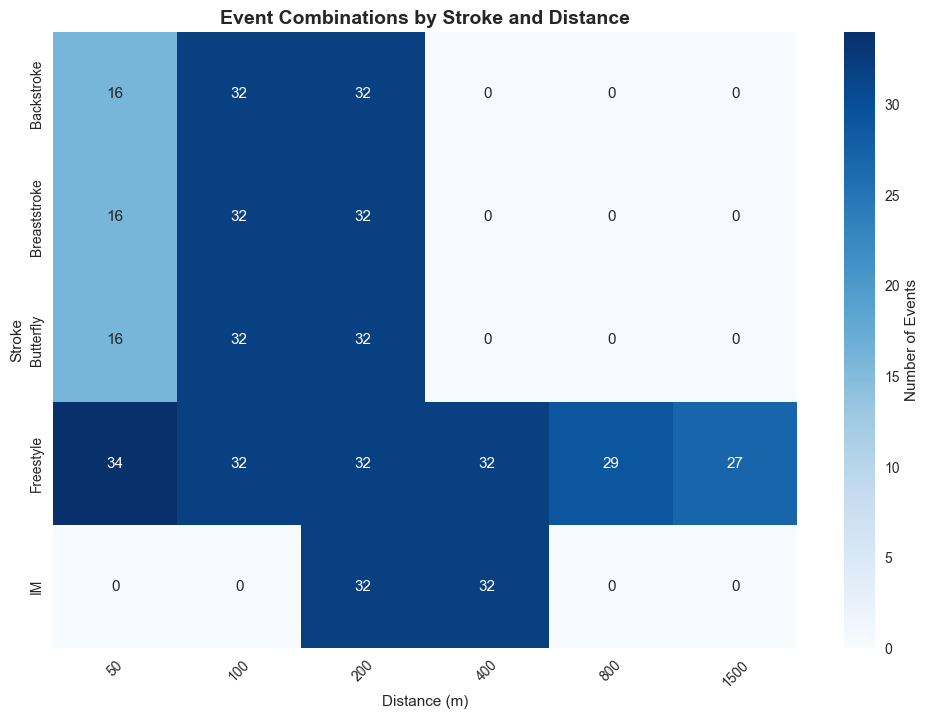

In [12]:
# Event Combos

event_combos = df.groupby(['stroke', 'distance']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(event_combos, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Number of Events'})
plt.title('Event Combinations by Stroke and Distance', fontsize=14, fontweight='bold')
plt.xlabel('Distance (m)')
plt.ylabel('Stroke')
plt.xticks(rotation=45)
plt.savefig('../outputs/plots/event_combos_heatmap.png', dpi=300)
#plt.tight_layout()
plt.show()


In [13]:
# Meet Analysis

meet_stats = df.groupby('meet').agg({
    'event': 'count',
    'num_entries': ['sum', 'mean'],
    'num_records': 'sum',
    'meet_category': 'first'
}).round(1)
meet_stats.columns = ['Events', 'Total_Swimmers', 'Avg_Entries', 'Total_Records', 'Category']  
meet_stats = meet_stats.sort_values(by='Total_Swimmers', ascending=False)
display(meet_stats)

category_stats = df.groupby('meet_category').agg({
    'meet': 'nunique',
    'event': 'count',
    'num_entries': ['sum', 'mean'],
    'num_records': 'sum'
}).round(1)
category_stats.columns = ['Total_Meets', 'Total_Events', 'Total_Swimmers', 'Avg_Entries', 'Total_Records']
category_stats = category_stats.sort_values(by='Total_Swimmers', ascending=False)
display(category_stats)

,Events,Total_Swimmers,Avg_Entries,Total_Records,Category
meet,,,,,
Santa Clara Final Results,42,2408,57.3,84,tyr-pro-swim-series-results
2023 Tyr Pro Swim Series Westmont,34,1288,37.9,97,tyr-pro-swim-series-results
U S Olympic Team Trials Wave Ii Complete Meet Results,28,1249,44.6,83,olympic-trials-results
Knoxville,28,1232,44.0,81,tyr-pro-swim-series-results
2023 Tyr Pro Swim Series Mission Viejo,34,1212,35.6,97,tyr-pro-swim-series-results
Complete Meet Results 2023 Tyr Pro Swim Series Fort Lauderdale,34,1174,34.5,98,tyr-pro-swim-series-results
2023 Tyr Pro Swim Series Knoxville Meet Results,34,1018,29.9,98,tyr-pro-swim-series-results
Phillips 66 Intl Team Trials,34,921,27.1,99,national-championships
2020 Us Olympic Team Trials Complete Wave I Results,28,767,27.4,82,olympic-trials-results


,Total_Meets,Total_Events,Total_Swimmers,Avg_Entries,Total_Records
meet_category,,,,,
tyr-pro-swim-series-results,11,351,11058,31.5,972
national-championships,3,83,2141,25.8,239
olympic-trials-results,2,56,2016,36.0,165


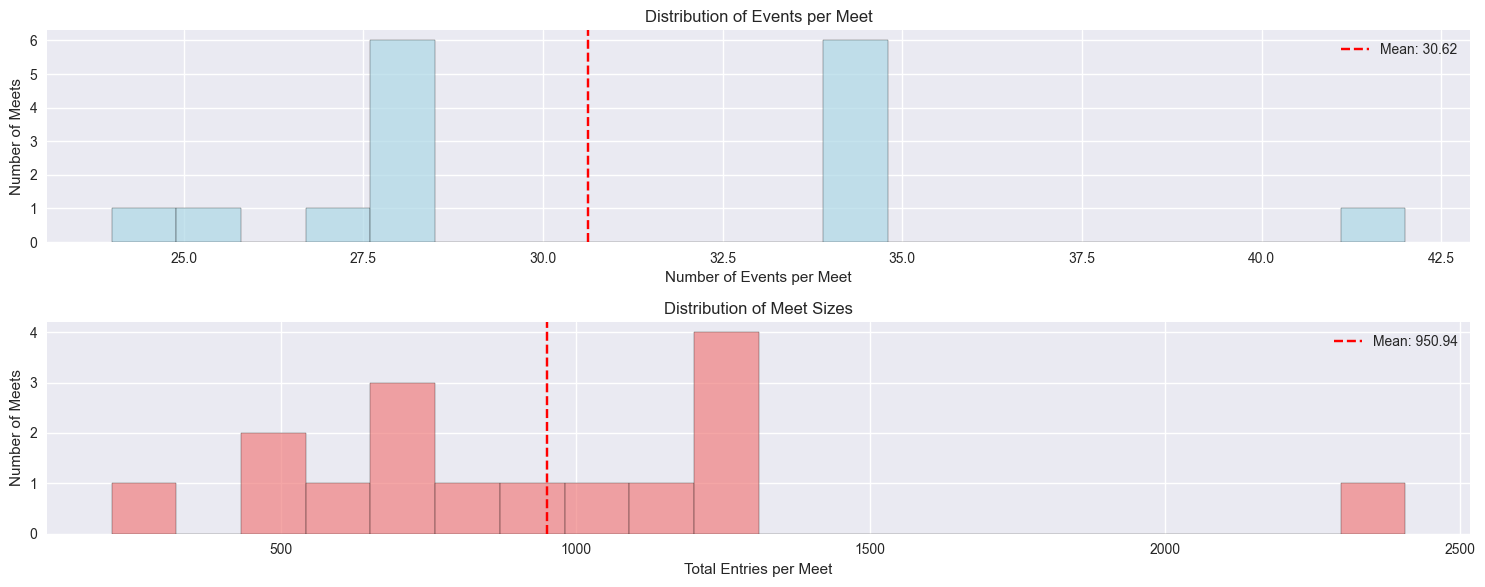

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(15, 6))

meet_event_counts = df.groupby('meet')['event'].count()
axes[0].hist(meet_event_counts, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
axes[0].set_title('Distribution of Events per Meet')
axes[0].set_xlabel('Number of Events per Meet')
axes[0].set_ylabel('Number of Meets')
axes[0].axvline(meet_event_counts.mean(), color='red', linestyle='--', label=f'Mean: {meet_event_counts.mean():.2f}')
axes[0].legend()

meet_swimmer_counts = df.groupby('meet')['num_entries'].sum()
axes[1].hist(meet_swimmer_counts, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].set_title('Distribution of Meet Sizes')
axes[1].set_xlabel('Total Entries per Meet')
axes[1].set_ylabel('Number of Meets')
axes[1].axvline(meet_swimmer_counts.mean(), color='red', linestyle='--', label=f'Mean: {meet_swimmer_counts.mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('../outputs/plots/meet_analysis.png', dpi=300)
plt.show()

In [20]:
# Record Analysis

all_records = []

for idx, row in df.iterrows():
    try:
        records = ast.literal_eval(row['records'])
        for record in records:
            all_records.append({
                'event_id' : idx,
                'gender': row['gender'],
                'distance': row['distance'],
                'stroke': row['stroke'],
                'record_type' : record[0],
                'time': record[1],
                'date': record[2],
                'athlete': record[3],
                'team': record[4] if len(record) > 4 else None,
            })
    except (ValueError, SyntaxError):
        print(f"Skipping invalid records for event {idx}")

records_df = pd.DataFrame(all_records)
records_df.head()

record_type_counts = records_df['record_type'].value_counts()
for record_type, count in record_type_counts.items():
    print(f"{record_type}: {count:,} records")
    



World: 483 records
American: 476 records
U.S. Open: 417 records


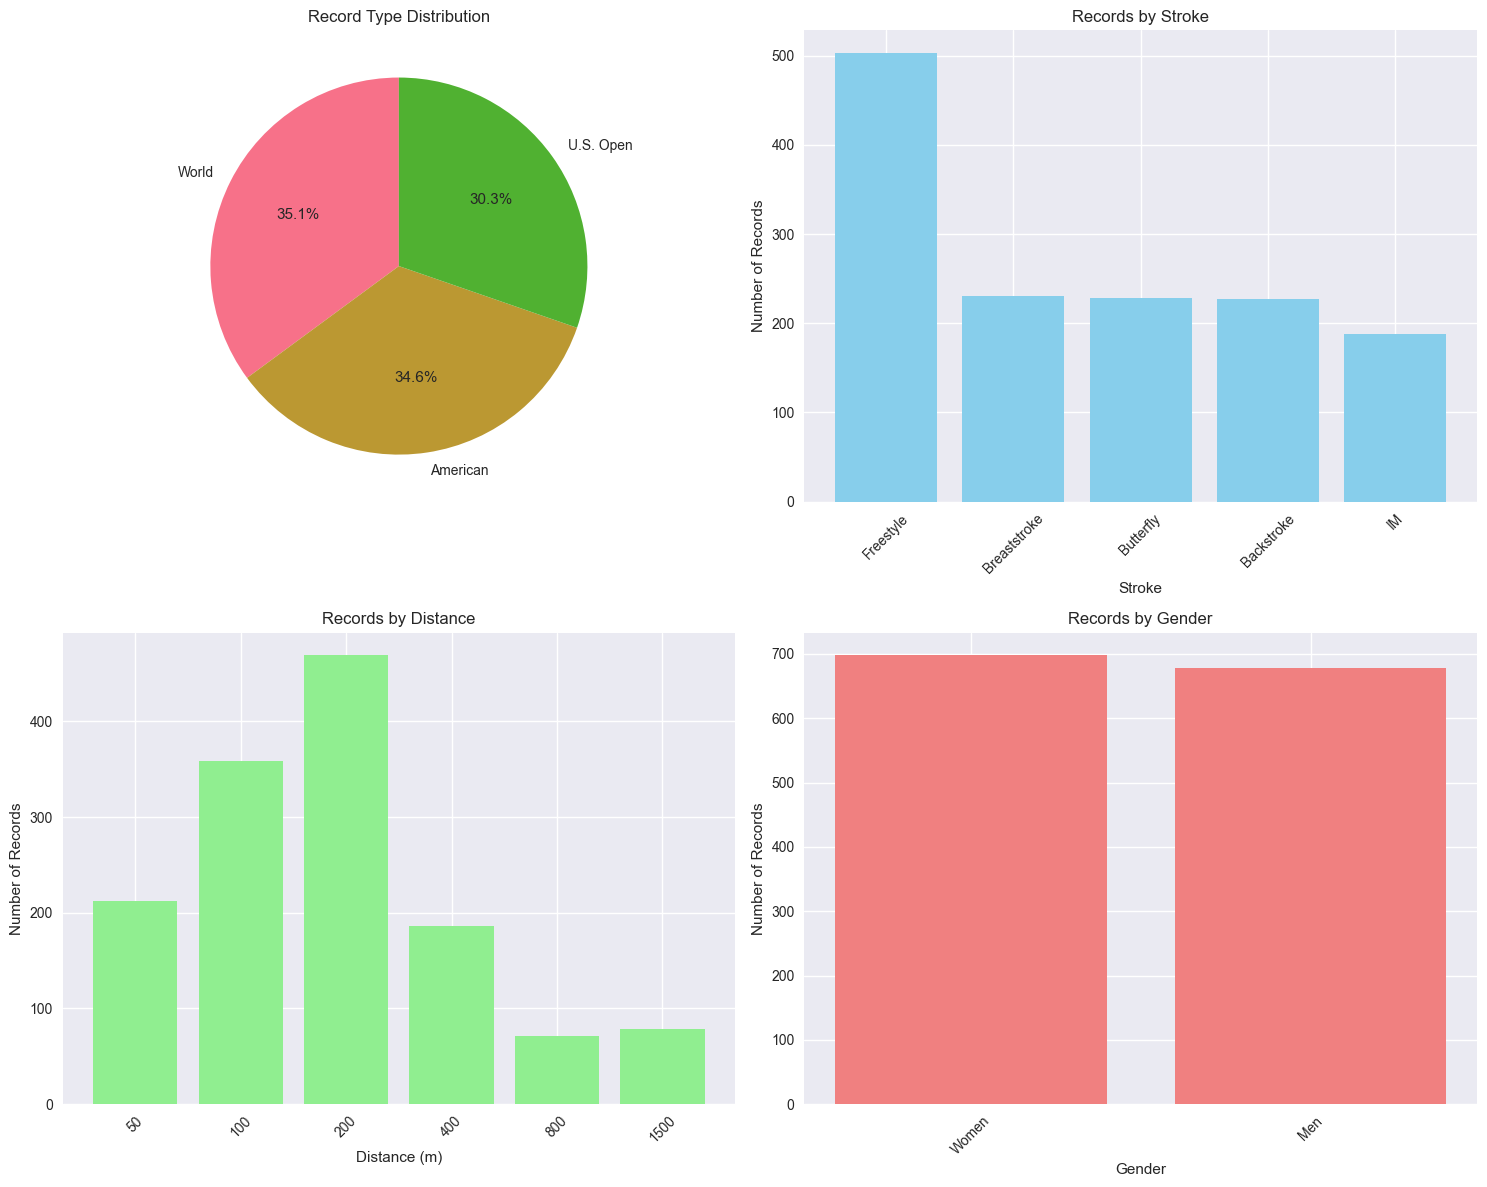

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle

axes[0, 0].pie(record_type_counts.values, labels=record_type_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Record Type Distribution')

stroke_records = records_df['stroke'].value_counts()
axes[0, 1].bar(stroke_records.index.astype(str), stroke_records.values, color='skyblue')
axes[0, 1].set_title('Records by Stroke')
axes[0, 1].set_xlabel('Stroke')
axes[0, 1].set_ylabel('Number of Records')
axes[0, 1].tick_params(axis='x', rotation=45)

distance_records = records_df['distance'].value_counts().sort_index()
axes[1, 0].bar(distance_records.index.astype(str), distance_records.values, color='lightgreen')
axes[1, 0].set_title('Records by Distance')
axes[1, 0].set_xlabel('Distance (m)')
axes[1, 0].set_ylabel('Number of Records')
axes[1, 0].tick_params(axis='x', rotation=45)

gender_records = records_df['gender'].value_counts()
axes[1, 1].bar(gender_records.index.astype(str), gender_records.values, color='lightcoral')
axes[1, 1].set_title('Records by Gender')
axes[1, 1].set_xlabel('Gender')
axes[1, 1].set_ylabel('Number of Records')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../outputs/plots/record_analysis.png', dpi=300)
plt.show()


In [ ]:
# Frequency of Record Holders

top_athletes = records_df['athlete'].value_counts().head(20)

for athete, count in top_athletes.items():
    print(f"{athete}: {count:,} records")


Michael Phelps: 113 records
Katie Ledecky: 110 records
Caeleb Dressel: 90 records
Regan Smith: 67 records
Aaron Peirsol: 62 records
Sarah Sjostrom: 52 records
Lilly King: 48 records
Ryan Lochte: 47 records
Simone Manuel: 47 records
Katinka Hosszu: 38 records
Michael Andrew: 33 records
Larsen Jensen: 31 records
Rebecca Soni: 29 records
Josh Prenot: 29 records
Cesar Cielo: 26 records
Allison Schmitt: 26 records
Ryan Murphy: 26 records
Adam Peaty: 24 records
Paul Biedermann: 24 records
Bobby Finke: 23 records


In [39]:
def time_to_seconds(time_str):
    try:
        if ':' in time_str:
            parts = time_str.split(':')
            if len(parts) == 2:  # MM:SS format
                return int(parts[0]) * 60 + float(parts[1])
            elif len(parts) == 3:  # HH:MM:SS format
                return int(parts[0]) * 3600 + int(parts[1]) * 60 + float(parts[2])
        else:
            return float(time_str)
    except ValueError:
        return np.nan  
    
# Sample some events
#sample_events = df.sample(min(100, len(df)), random_state=42)
race_results = []

for idx, row in df.iterrows():
    try:
        entries = ast.literal_eval(row['entries'])
        for entry in entries:
            if len (entry) >= 6:
                race_results.append({
                    'event_id': idx,
                    'gender': row['gender'],
                    'distance': row['distance'],
                    'stroke': row['stroke'],
                    'meet': row['meet'],
                    'rank': entry[0],
                    'name': entry[1],
                    'age': entry[2],
                    'team': entry[3],
                    'seed_time': entry[4],
                    'final_time': entry[5]
                })
    except (ValueError, SyntaxError):
        print(f"Skipping invalid entries for event {idx}")

if len(race_results) > 0:
    results_df = pd.DataFrame(race_results)

    results_df['seed_time'] = results_df['seed_time'].apply(time_to_seconds)
    results_df['final_time'] = results_df['final_time'].apply(time_to_seconds)
    results_df['time_diff'] = results_df['seed_time'] - results_df['final_time']

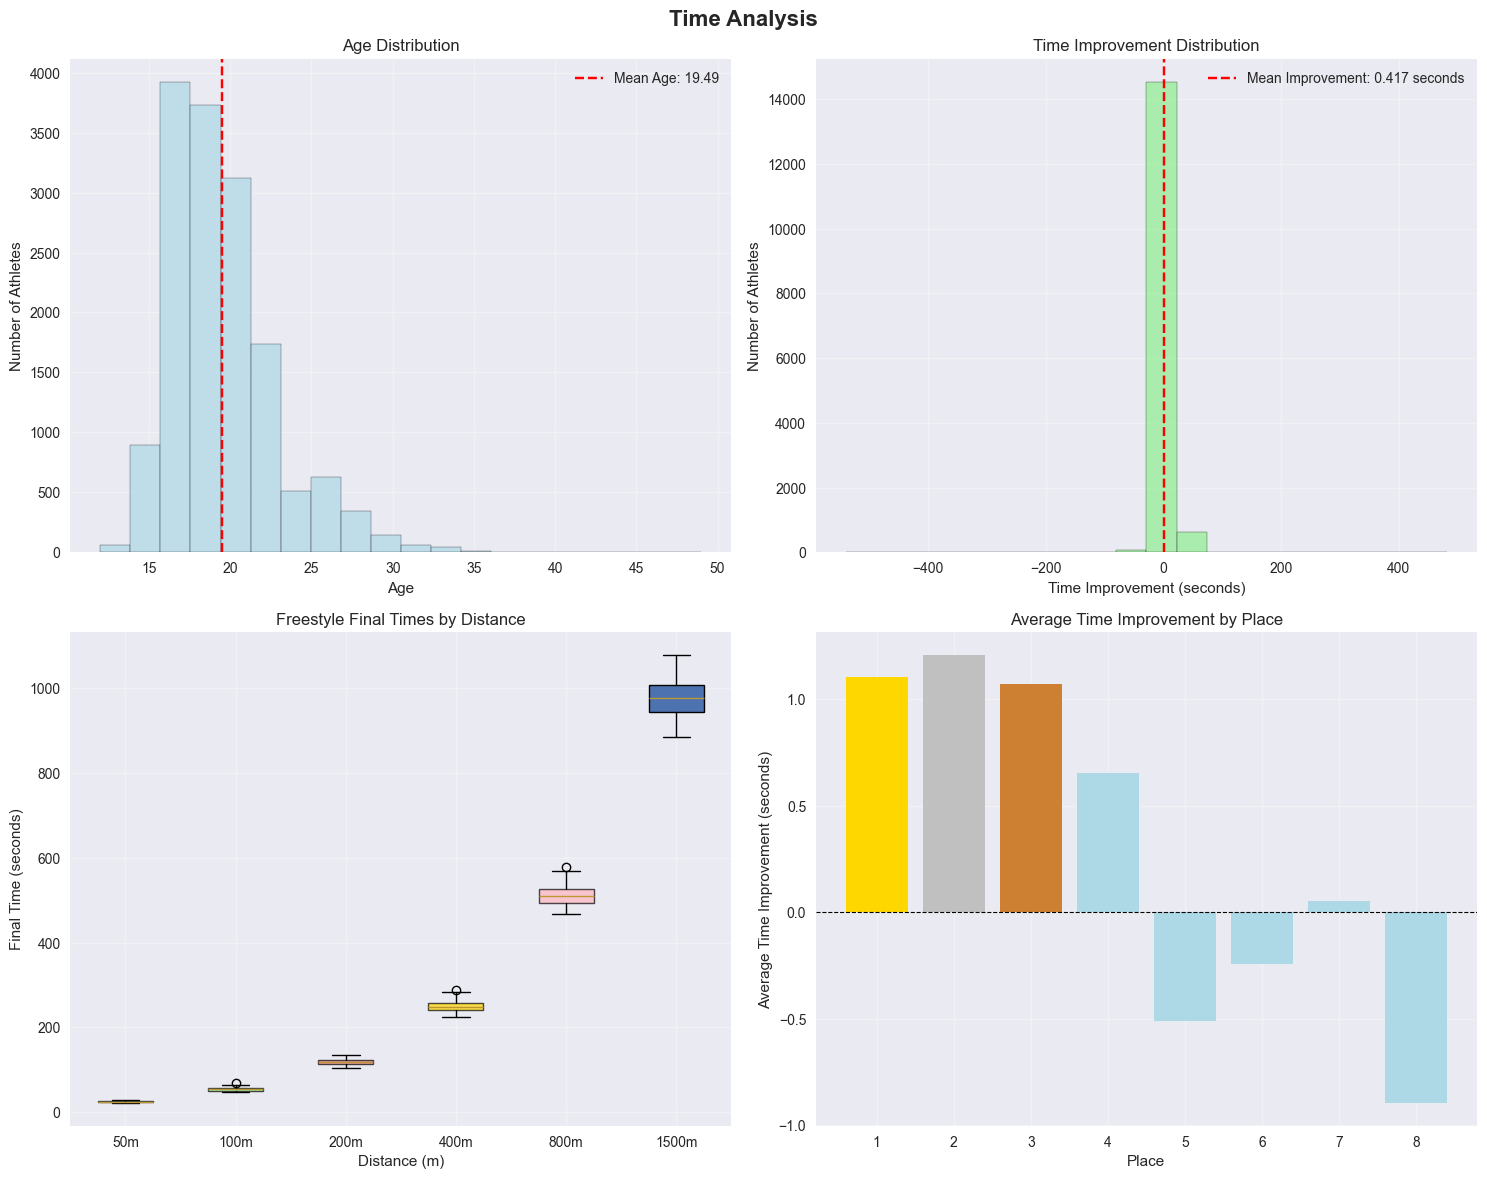

Average swimmer age: 19.5 years
Average time improvement: 0.417 seconds
Swimmers who improved: 48.9%
Swimmers who went slower: 50.8%
Standard deviation of time improvement: 14.795 seconds


In [50]:
# Plotting time analysis

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Time Analysis', fontsize=16, fontweight='bold')

ages = results_df['age']
axes[0,0].hist(ages, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
axes[0,0].set_title('Age Distribution')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Number of Athletes')
mean_age = ages.mean()
axes[0,0].axvline(mean_age, color='red', linestyle='--', label=f'Mean Age: {mean_age:.2f}')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

improvement = results_df['time_diff']
axes[0, 1].hist(improvement.dropna(), bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Time Improvement Distribution')
axes[0, 1].set_xlabel('Time Improvement (seconds)')
axes[0, 1].set_ylabel('Number of Athletes')
mean_improvement = improvement.mean()
axes[0, 1].axvline(mean_improvement, color='red', linestyle='--', label=f'Mean Improvement: {mean_improvement:.3f} seconds')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

freestyle_results = results_df[results_df['stroke'] == 'Freestyle'].copy()
distance_groups = freestyle_results.groupby('distance')['final_time'].apply(list)
distances_with_data = [d for d in distance_groups.index if len(distance_groups[d]) >= 3]
if distances_with_data:            
    data_for_boxplot = [distance_groups[d] for d in distances_with_data]

bp = axes[1,0].boxplot(data_for_boxplot, labels=[f'{d}m' for d in distances_with_data], patch_artist=True)
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold', 'lightpink']
for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_alpha(0.7)
axes[1,0].set_title('Freestyle Final Times by Distance')
axes[1,0].set_xlabel('Distance (m)')
axes[1,0].set_ylabel('Final Time (seconds)')
axes[1,0].grid(True, alpha=0.3)

rank_data = results_df[results_df['rank'] <= 8].copy()
rank_improvement = rank_data.groupby('rank')['time_diff'].mean()
colors = ['gold', 'silver', '#CD7F32'] + ['lightblue'] * 5
axes[1, 1].bar(rank_improvement.index.astype(str), rank_improvement.values, color=colors[:len(rank_improvement)])
axes[1, 1].set_title('Average Time Improvement by Place')
axes[1, 1].set_xlabel('Place')
axes[1, 1].set_ylabel('Average Time Improvement (seconds)')
axes[1, 1].axhline(0, color='black', linestyle='--', linewidth=0.8)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/plots/time_analysis.png', dpi=300)
plt.show()

print(f"Average swimmer age: {ages.mean():.1f} years")
print(f"Average time improvement: {improvement.mean():.3f} seconds")
print(f"Swimmers who improved: {(improvement > 0).mean()*100:.1f}%")
print(f"Swimmers who went slower: {(improvement < 0).mean()*100:.1f}%")
print(f"Standard deviation of time improvement: {improvement.std():.3f} seconds")


In [52]:
time_analysis = results_df.groupby(['gender', 'distance', 'stroke']).agg({
    'final_time': ['count', 'mean', 'std', 'min', 'max'],
    'time_diff': ['mean', 'std']
}).round(2)
time_analysis.columns = ['Count', 'Mean_Time', 'Std_Time', 'Best_Time', 'Worst_Time', 'Avg_Improvement', 'Std_Improvement']
time_analysis = time_analysis.sort_values('Mean_Time')
time_analysis['CV'] = time_analysis['Std_Time'] / time_analysis['Mean_Time'] 

display(time_analysis)

    

Count  Mean_Time  Std_Time  Best_Time  \
gender distance stroke                                                
Men    50       Freestyle       667      23.55      0.85      21.29   
                Butterfly       337      25.32      1.18      22.87   
Women  50       Freestyle       610      26.31      0.82      24.40   
Men    50       Backstroke      247      26.87      1.28      23.92   
Women  50       Butterfly       338      28.16      1.24      25.49   
Men    50       Breaststroke    288      29.44      1.40      26.55   
Women  50       Backstroke      280      30.00      1.42      27.25   
                Breaststroke    238      33.43      1.59      29.76   
Men    100      Freestyle       663      51.29      1.59      47.72   
                Butterfly       649      55.27      1.95      50.20   
Women  100      Freestyle       658      57.21      1.74      53.23   
Men    100      Backstroke      545      57.34      1.99      52.20   
Women  100      Butterfly       564      61.69      2.03      56.28   
                Backstroke      548      63.63      2.16      58.35   
Men    100      Breaststroke    607      64.08      2.27      58.37   
Women  100      Breaststroke    505      72.19      2.74      65.58   
Men    200      Freestyle       644     113.05      3.34     105.25   
                Butterfly       461     123.66      4.46     114.10   
Women  200      Freestyle       562     123.67      3.33     114.56   
Men    200      Backstroke      450     125.93      5.04     115.01   
                IM              508     126.92      4.55     116.21   
Women  200      Butterfly       375     136.78      4.87     126.35   
                Backstroke      450     137.55      4.70     125.13   
Men    200      Breaststroke    511     140.17      5.55     129.51   
Women  200      IM              505     140.61      4.69     127.42   
                Breaststroke    436     156.12      6.22     141.07   
Men    400      Freestyle       525     241.61      7.31     224.83   
Women  400      Freestyle       421     260.11      7.32     239.52   
Men    400      IM              384     271.50      8.81     249.33   
Women  400      IM              363     296.67      8.50     276.04   
Men    800      Freestyle       296     497.92     14.13     468.22   
Women  800      Freestyle       203     529.72     14.90     489.27   
Men    1500     Freestyle       217     951.89     27.96     885.72   
Women  1500     Freestyle       160    1013.55     28.18     938.99   

                              Worst_Time  Avg_Improvement  Std_Improvement  \
gender distance stroke                                                       
Men    50       Freestyle          28.43            -0.21             0.47   
                Butterfly          30.47            12.38            15.41   
Women  50       Freestyle          29.40            -0.19             0.50   
Men    50       Backstroke         30.47            10.11            14.68   
Women  50       Butterfly          32.56            14.97            17.18   
Men    50       Breaststroke       35.33            12.47            17.09   
Women  50       Backstroke         34.84            12.75            16.68   
                Breaststroke       38.97            10.74            17.61   
Men    100      Freestyle          56.94            -0.44             0.84   
                Butterfly          64.43            -0.47             1.12   
Women  100      Freestyle          68.05            -0.50             1.07   
Men    100      Backstroke         64.25            -0.28             1.04   
Women  100      Butterfly          69.26            -0.38             1.14   
                Backstroke         74.02            -0.41             1.25   
Men    100      Breaststroke       72.39            -0.43             1.20   
Women  100      Breaststroke       80.96            -0.40             1.45   
Men    200      Freestyle         123.44            -0.94            

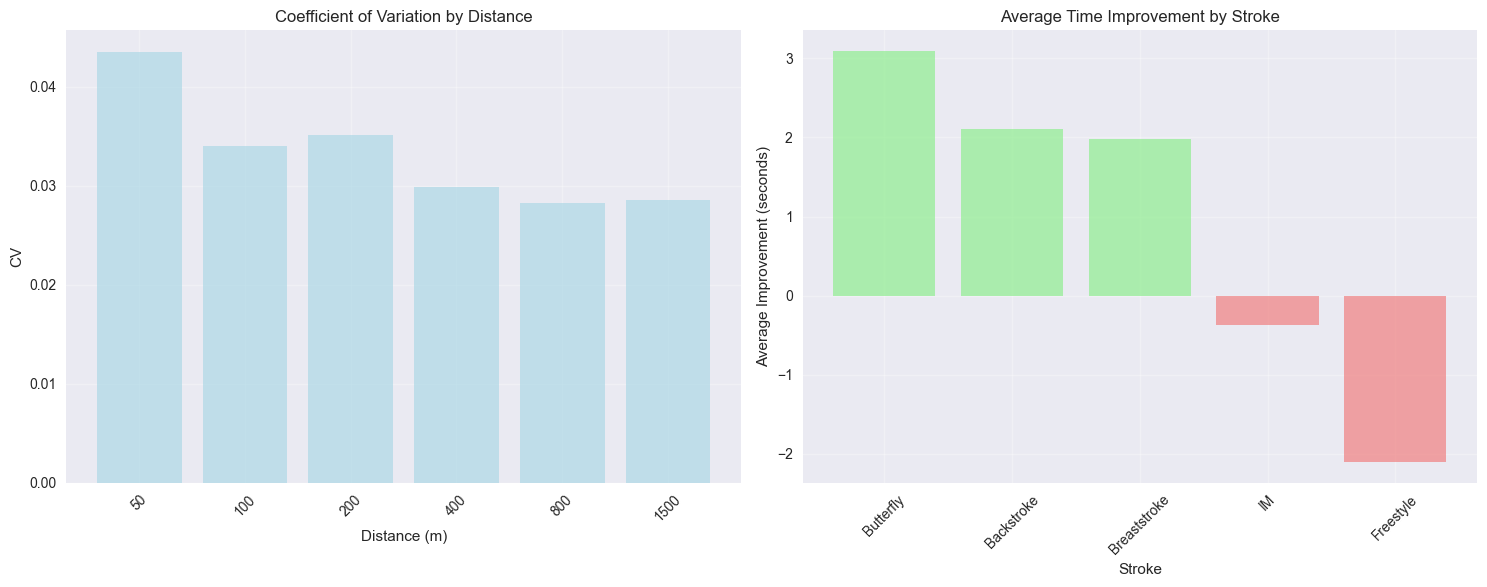

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

cv_by_distance = time_analysis.reset_index().groupby('distance')['CV'].mean().sort_index()
axes[0].bar(cv_by_distance.index.astype(str), cv_by_distance.values, color='lightblue', alpha=0.7)
axes[0].set_title('Coefficient of Variation by Distance')
axes[0].set_xlabel('Distance (m)')
axes[0].set_ylabel('CV')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

improvement_by_stroke = results_df.groupby('stroke')['time_diff'].mean().sort_values(ascending=False)
colors = ['lightgreen' if x > 0 else 'lightcoral' for x in improvement_by_stroke.values]
axes[1].bar(improvement_by_stroke.index, improvement_by_stroke.values, color=colors, alpha=0.7)
axes[1].set_title('Average Time Improvement by Stroke')
axes[1].set_xlabel('Stroke')
axes[1].set_ylabel('Average Improvement (seconds)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)  


plt.tight_layout()
plt.savefig('../outputs/plots/time_analysis_summary.png', dpi=300)
plt.show()


In [ ]:
competitve_analysis = []

records_by_event = {}
for idx, row in df.iterrows():
    try:
        records = ast.literal_eval(row['records'])
        record_holders = []
        record_times = []
        for record in records:
            if len(record) >= 5:
                record_holders.append(record[3])  # athlete name
                record_times.append(time_to_seconds(record[1]))  # record time
        records_by_event[idx] = {
            'holders': record_holders,
            'times': record_times
        }
    except:
        records_by_event[idx] = {'holders': [], 'times': []}

for idx, row in df.iterrows():
    try:
        entries = ast.literal_eval(row['entries'])
        times = []
        for entry in entries:
            final_time = time_to_seconds(entry[5])
            seed_time = time_to_seconds(entry[4])
            if not pd.isna(final_time) and not pd.isna(seed_time) and final_time > 0:
                times.append({
                    'rank': entry[0],
                    'name': entry[1],
                    'final': final_time,
                    'seed': seed_time,
                    'time_diff': seed_time - final_time
                })
        if times:
            times_sorted = sorted(times, key=lambda x: x['final'])
            gap_1_2 = times_sorted[1]['final'] - times_sorted[0]['final']  # 2nd place - 1st place
            gap_2_3 = times_sorted[2]['final'] - times_sorted[1]['final'] if len(times_sorted) > 2 else np.nan  # 3rd place - 2nd place
            
            seed_times_sorted = sorted(times, key=lambda x: x['seed'])
            seed_gap_1_2 = seed_times_sorted[1]['seed'] - seed_times_sorted[0]['seed']  # 2nd seed - 1st seed
            seed_gap_2_3 = seed_times_sorted[2]['seed'] - seed_times_sorted[1]['seed'] if len(seed_times_sorted) > 2 else np.nan  # 3rd seed - 2nd seed
            
            top_seed_won = seed_times_sorted[0]['name'] == times_sorted[0]['name']

            competitve_analysis.append({
                'event_id': idx,
                'gender': row['gender'],
                'distance': row['distance'],
                'stroke': row['stroke'],
                'meet': row['meet'],
                'field_size': len(times),
                'gap_1_2': gap_1_2,
                'gap_2_3': gap_2_3,
                'seed_gap_1_2': seed_gap_1_2,
                'seed_gap_2_3': seed_gap_2_3,
                'top_seed_won': top_seed_won,
                'avg_diff': np.mean([t['time_diff'] for t in times]),
                'time_spread': times_sorted[-1]['final'] - times_sorted[0]['final'],
                'winner_time': times_sorted[0]['final'],
                'top_seed_time': seed_times_sorted[0]['seed'],
                'record_holders': records_by_event[idx]['holders'],
                'record_times': records_by_event[idx]['times'],
                'seeded_names': [t['name'] for t in times],
                'top_seed_is_record_holder': seed_times_sorted[0]['name'] in records_by_event[idx]['holders'],
                'winner_is_record_holder': times_sorted[0]['name'] in records_by_event[idx]['holders'],
                'num_record_holders_seeded': len([name for name in [t['name'] for t in times] if name in records_by_event[idx]['holders']]),
                'pct_record_holders_seeded': len([name for name in [t['name'] for t in times] if name in records_by_event[idx]['holders']]) / len(times) if len(times) > 0 else 0,
                'fastest_record_time': min(records_by_event[idx]['times']) if records_by_event[idx]['times'] else np.nan,
                'winner_vs_fastest_record': times_sorted[0]['final'] - min(records_by_event[idx]['times']) if records_by_event[idx]['times'] else np.nan
            })
    except (ValueError, SyntaxError):
        print(f"Skipping invalid entries for event {idx}")
        continue


comp_df = pd.DataFrame(competitve_analysis)

if len(comp_df) > 0:
    print(f"\nRECORD HOLDER ANALYSIS:")
    print(f"Top seeds who are record holders: {comp_df['top_seed_is_record_holder'].mean()*100:.1f}%")
    print(f"Winners who are record holders: {comp_df['winner_is_record_holder'].mean()*100:.1f}%")
    print(f"Average record holders per field: {comp_df['num_record_holders_seeded'].mean():.1f}")
    print(f"Average % of field that are record holders: {comp_df['pct_record_holders_seeded'].mean()*100:.1f}%")
    print(f"Events with 0 record holders: {(comp_df['num_record_holders_seeded'] == 0).mean()*100:.1f}%")
    print(f"Events with 1+ record holders: {(comp_df['num_record_holders_seeded'] > 0).mean()*100:.1f}%")  





RECORD HOLDER ANALYSIS:
Top seeds who are record holders: 6.9%
Winners who are record holders: 8.4%
Average record holders per field: 0.1
Average % of field that are record holders: 0.5%
Events with 0 record holders: 85.9%
Events with 1+ record holders: 14.1%


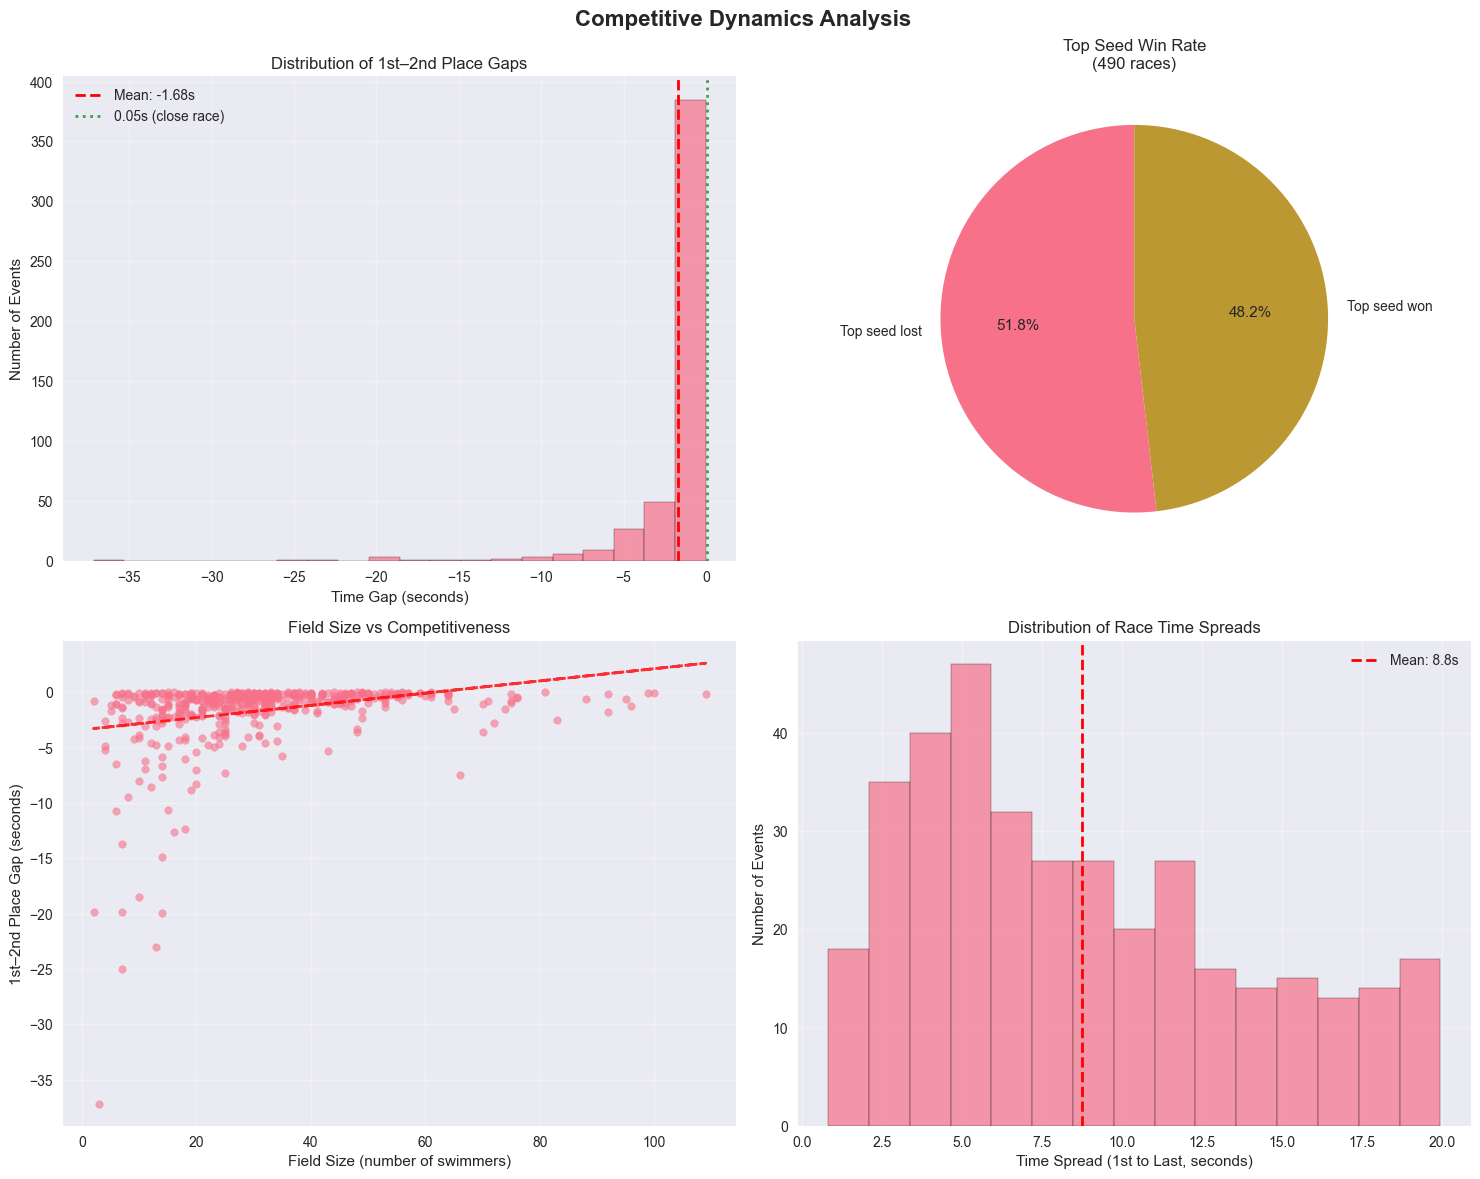


Most competitive strokes (smallest avg gaps):
1. Freestyle: -2.51s
2. IM: -2.49s
3. Breaststroke: -0.94s
4. Butterfly: -0.81s
5. Backstroke: -0.67s

Most competitive distances (smallest avg gaps):
1. 1500m: -8.02s
2. 800m: -5.57s
3. 400m: -2.59s
4. 200m: -1.17s
5. 100m: -0.57s
6. 50m: -0.22s


In [ ]:
# Field Analysis

if len(comp_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Competitive Dynamics Analysis', fontsize=16, fontweight='bold')
  
    valid_gaps = comp_df['gap_1_2']
    if len(valid_gaps) > 0:
        axes[0,0].hist(valid_gaps, bins=20, alpha=0.7, edgecolor='black')
        axes[0,0].set_title('Distribution of 1st–2nd Place Gaps')
        axes[0,0].set_xlabel('Time Gap (seconds)')
        axes[0,0].set_ylabel('Number of Events')
        mean_gap = valid_gaps.mean()
        axes[0,0].axvline(mean_gap, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_gap:.2f}s')
        axes[0,0].axvline(0.05, color='green', linestyle=':', linewidth=2, alpha=0.7, label='0.05s (close race)')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
    
    seed_performance = comp_df['top_seed_won'].value_counts()
    labels = ['Top seed lost', 'Top seed won']
    wedges, texts, autotexts = axes[0,1].pie(
        seed_performance.values, labels=labels, autopct='%1.1f%%', startangle=90
    )
    axes[0,1].set_title(f'Top Seed Win Rate\n({len(comp_df)} races)')
    
    if len(comp_df) > 10:
        axes[1,0].scatter(comp_df['field_size'], comp_df['gap_1_2'], alpha=0.6, s=30)
        axes[1,0].set_title('Field Size vs Competitiveness')
        axes[1,0].set_xlabel('Field Size (number of swimmers)')
        axes[1,0].set_ylabel('1st–2nd Place Gap (seconds)')
        axes[1,0].grid(True, alpha=0.3)
        if len(comp_df) > 20:
            z = np.polyfit(comp_df['field_size'], comp_df['gap_1_2'], 1)
            p = np.poly1d(z)
            axes[1,0].plot(comp_df['field_size'], p(comp_df['field_size']), "r--", alpha=0.8, linewidth=2)
    
    valid_spread = comp_df['time_spread'][(comp_df['time_spread'] > 0) & (comp_df['time_spread'] < 20)]
    if len(valid_spread) > 0:
        axes[1,1].hist(valid_spread, bins=15, alpha=0.7, edgecolor='black')
        axes[1,1].set_title('Distribution of Race Time Spreads')
        axes[1,1].set_xlabel('Time Spread (1st to Last, seconds)')
        axes[1,1].set_ylabel('Number of Events')
        mean_spread = valid_spread.mean()
        axes[1,1].axvline(mean_spread, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_spread:.1f}s')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
    
    #plt.tight_layout()
    plt.savefig('../outputs/plots/competitive_dynamics_analysis.png', dpi=300)
    plt.show()
    
    stroke_comp = comp_df.groupby('stroke')['gap_1_2'].mean().sort_values()
    print("\nMost competitive strokes (smallest avg gaps):")
    for i, (stroke, gap) in enumerate(stroke_comp.items(), 1):
        print(f"{i}. {stroke}: {gap:.2f}s")
    
    distance_comp = comp_df.groupby('distance')['gap_1_2'].mean().sort_values()
    print("\nMost competitive distances (smallest avg gaps):")
    for i, (distance, gap) in enumerate(distance_comp.items(), 1):
        print(f"{i}. {distance}m: {gap:.2f}s")
else:
    pass

